In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Evaluation

### Correction:
During Evaluation we found out, that we did the One-Hot Encoding incorrectly.
Pandas creates more entries on every row and therefore we were supposed to have 115 Dimensions instead of 41.

So we do this correctly here now

In [2]:
import gzip

with gzip.open('./kddcup.data_10_percent.gz') as f:
    kdd_data = pd.read_csv(f, header=None)

kdd_data = pd.concat([kdd_data, pd.get_dummies(kdd_data[1], drop_first=True)], axis=1)
kdd_data = pd.concat([kdd_data, pd.get_dummies(kdd_data[2], drop_first=True)], axis=1)
kdd_data = pd.concat([kdd_data, pd.get_dummies(kdd_data[3], drop_first=True)], axis=1)

true_labels = kdd_data[41]
kdd_data = kdd_data.drop(columns=[1,2,3,41])
print (kdd_data.shape)

(494021, 115)


We now load the [labeled Test data set](http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz) from the KDD99 website
also encode it via one-hot encoding

In [3]:
kdd_data_test = None
with gzip.open('./corrected.gz') as f:
    kdd_data_test = pd.read_csv(f, header=None)

true_labels_test = kdd_data_test[41]

kdd_data_test = pd.concat([kdd_data_test, pd.get_dummies(kdd_data_test[1], drop_first=True)], axis=1)
kdd_data_test = pd.concat([kdd_data_test, pd.get_dummies(kdd_data_test[2], drop_first=True)], axis=1)
kdd_data_test = pd.concat([kdd_data_test, pd.get_dummies(kdd_data_test[3], drop_first=True)], axis=1)

kdd_data_test = kdd_data_test.drop(columns=[1,2,3,41])

kdd_data_test.shape

(311029, 114)

However this results in two sets, that have different shapes. Because the test set has some protocols and columns that are missing in the other set. We use the align function from pandas which will drop columns for the sake of aligning both data frames, which is unfortunate but necessary to continue our evaluation since we still need the same amount of features to use our PCA approach and for calculating the distances

In [4]:
aligned_train, aligned_test = kdd_data.align(kdd_data_test, join='inner', axis=1)
scaler = MinMaxScaler()
data_train_scaled = scaler.fit_transform(aligned_train)
data_test_scaled = scaler.fit_transform(aligned_test)
print(aligned_train.shape, aligned_test.shape)

(494021, 113) (311029, 113)


The increased number of features also changed our approach to selecting 18 Principal Components instead of 9 for explaining 0.99 percent of variance

(494021, 113) dimensions reduced to (494021, 18) dimensions


Text(0, 0.5, 'cumulative explained variance')

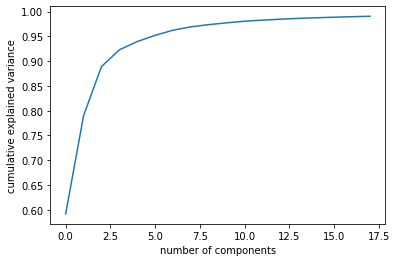

In [5]:
pca = PCA(n_components = 0.99)
pca.fit(data_train_scaled)
train_pca = pca.transform(data_train_scaled)
print("{} dimensions reduced to {} dimensions".format(data_train_scaled.shape, train_pca.shape))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

With our adjusted approach we now try to evaluate the approach of 4 Clusters and then run it against a Test set

In [6]:
km_test = KMeans(n_clusters=4).fit(train_pca)

First we again calculate a few distance Thresholds since we are still using the assumption, that anomalies are far away from Clusters from the paper "Anomaly Detection" by Chandola et al.

In [30]:
distances = []
for index,data in enumerate(train_pca):
    cluster = km_test.labels_[index]
    dist = np.linalg.norm(data - km_test.cluster_centers_[cluster])
    distances.append(dist)

distances = sorted(distances)
median = np.median(distances)
average = np.average(distances)
max_dist_close = max(distances) * 0.75
min_dist_close = min(distances) *  1.5
print("median: ", median)
print("average: ", average)
print("max_dist_close: ", max_dist_close)
print("min_dist_close: ", min_dist_close)

median:  0.012171287771748147
average:  0.3378291228106857
max_dist_close:  2.012832245666405
min_dist_close:  0.0034671984198248653


We apply the same transform to the test set so that we can calculate everything correctly

(311029, 113) dimensions reduced to (494021, 18) dimensions


Text(0, 0.5, 'cumulative explained variance')

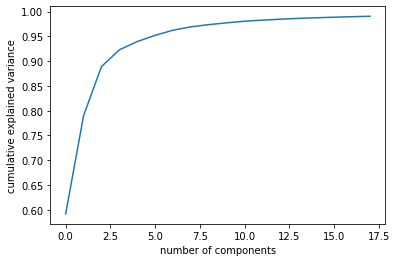

In [8]:
test_pca = pca.transform(data_test_scaled)
print("{} dimensions reduced to {} dimensions".format(data_test_scaled.shape, train_pca.shape))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We evaluate via the test set by testing each datapoint of the testset against a all clusters and chosing the closest cluster as the cluster to be assigned to.
If the distance is bigger than our chosen threshold then we categorize it as an anomaly otherwise we decide it to be normal traffic.
We create 4 lists of objects which will represent the true positive, the true negative, the false negative and the false positive.
A correctly classified anomaly is a true positive using the wording from the lecture slides
A correctly classified normal is a true negative
and for the incorrectly assigned anomaly and normal traffic we assign False Positive and False negative respectively.

In [9]:
def classify_testset(test_block, test_block_labels, test_range, threshold_dist, kmeans):
    correct_anomalies = []
    incorrect_anomalies = []
    correct_normal = []
    incorrect_normal = []
    for index,data in enumerate(test_block):
        idx = index + test_range[0]
        distance= min([np.linalg.norm(data-c) for c in kmeans.cluster_centers_])
        if distance > threshold_dist and test_block_labels[idx] != 'normal.':
            correct_anomalies.append(data)
        elif distance > threshold_dist and test_block_labels[idx] == 'normal.':
            incorrect_anomalies.append(data)
        elif distance <= threshold_dist and test_block_labels[idx] == 'normal.':
            correct_normal.append(data)
        elif distance <= threshold_dist and test_block_labels[idx] != 'normal.':
            incorrect_normal.append(data)
    return correct_anomalies, incorrect_anomalies, correct_normal, incorrect_normal

In [10]:
test_block_labels = true_labels_test
test_block = test_pca
test_range = [0, 500]

correct_anomalies, incorrect_anomalies, correct_normal, incorrect_normal = classify_testset(test_block, test_block_labels, test_range, median, km_test)
print('using median as threshold:')
print('---------------------------')
print('correctly classified as anomaly: ', len(correct_anomalies))
print('incorrectly classified as anomaly: ', len(incorrect_anomalies))
print('correctly classified as normal: ', len(correct_normal))
print('incorrectly classified as normal: ', len(incorrect_normal))
print('total number of anomalies', len([l for l in test_block_labels if l != 'normal.']))
print('total number of normal', len([l for l in test_block_labels if l == 'normal.']))
TP = len(correct_anomalies)
TN = len(correct_normal)
FN = len(incorrect_normal)
FP = len(incorrect_anomalies)

using median as threshold:
---------------------------
correctly classified as anomaly:  119673
incorrectly classified as anomaly:  60593
correctly classified as normal:  0
incorrectly classified as normal:  130763
total number of anomalies 250436
total number of normal 60593


In [11]:
precision = TP/(TP + FP)
recall = TP/(TP+FN)
false_positive_rate = FP/(FP+TN)
specifity = TN / (FP + TN)
negative_predictive_value = TN/ (TN + FN)
accuracy = (TP+TN) / (TP+FP+FN+TN)
F1 = 2 * (precision * recall) / (precision + recall)
print('precision', precision)
print('recall', recall)
print('false positive rate', false_positive_rate)
print('specifity ', specifity)
print('negative predictive value ', negative_predictive_value)
print('accuracy', accuracy)
print("F1 score ", F1)

precision 0.6638689492194868
recall 0.4778586145761791
false positive rate 1.0
specifity  0.0
negative predictive value  0.0
accuracy 0.3847647647003977
F1 score  0.5557113735250823


In [12]:
correct_anomalies, incorrect_anomalies, correct_normal, incorrect_normal = classify_testset(test_block, test_block_labels, test_range, average, km_test)
print('using average as threshold:')
print('---------------------------')
print('correctly classified as anomaly: ', len(correct_anomalies))
print('incorrectly classified as anomaly: ', len(incorrect_anomalies))
print('correctly classified as normal: ', len(correct_normal))
print('incorrectly classified as normal: ', len(incorrect_normal))
print('total number of anomalies', len([l for l in test_block_labels if l != 'normal.']))
print('total number of normal', len([l for l in test_block_labels if l == 'normal.']))
TP = len(correct_anomalies)
TN = len(correct_normal)
FN = len(incorrect_normal)
FP = len(incorrect_anomalies)

using average as threshold:
---------------------------
correctly classified as anomaly:  103511
incorrectly classified as anomaly:  60593
correctly classified as normal:  0
incorrectly classified as normal:  146925
total number of anomalies 250436
total number of normal 60593


In [13]:
precision = TP/(TP + FP)
recall = TP/(TP+FN)
false_positive_rate = FP/(FP+TN)
specifity = TN / (FP + TN)
negative_predictive_value = TN/ (TN + FN)
accuracy = (TP+TN) / (TP+FP+FN+TN)
F1 = 2 * (precision * recall) / (precision + recall)
print('precision', precision)
print('recall', recall)
print('false positive rate', false_positive_rate)
print('specifity ', specifity)
print('negative predictive value ', negative_predictive_value)
print('accuracy', accuracy)
print("F1 score ", F1)

precision 0.6307646370594258
recall 0.41332316440128414
false positive rate 1.0
specifity  0.0
negative predictive value  0.0
accuracy 0.33280176446569293
F1 score  0.4994017465142085


In [31]:
correct_anomalies, incorrect_anomalies, correct_normal, incorrect_normal = classify_testset(test_block, test_block_labels, test_range, max_dist_close, km_test)
print('using close to max distance as threshold:')
print('---------------------------')
print('correctly classified as anomaly: ', len(correct_anomalies))
print('incorrectly classified as anomaly: ', len(incorrect_anomalies))
print('correctly classified as normal: ', len(correct_normal))
print('incorrectly classified as normal: ', len(incorrect_normal))
print('total number of anomalies', len([l for l in test_block_labels if l != 'normal.']))
print('total number of normal', len([l for l in test_block_labels if l == 'normal.']))
TP = len(correct_anomalies)
TN = len(correct_normal)
FN = len(incorrect_normal)
FP = len(incorrect_anomalies)

using close to max distance as threshold:
---------------------------
correctly classified as anomaly:  1498
incorrectly classified as anomaly:  751
correctly classified as normal:  59842
incorrectly classified as normal:  248938
total number of anomalies 250436
total number of normal 60593


In [32]:
precision = TP/(TP + FP)
recall = TP/(TP+FN)
false_positive_rate = FP/(FP+TN)
specifity = TN / (FP + TN)
negative_predictive_value = TN/ (TN + FN)
accuracy = (TP+TN) / (TP+FP+FN+TN)
F1 = 2 * (precision * recall) / (precision + recall)
print('precision', precision)
print('recall', recall)
print('false positive rate', false_positive_rate)
print('specifity ', specifity)
print('negative predictive value ', negative_predictive_value)
print('accuracy', accuracy)
print("F1 score ", F1)

precision 0.666073810582481
recall 0.0059815681451548496
false positive rate 0.012394170943838398
specifity  0.9876058290561616
negative predictive value  0.19380141200854978
accuracy 0.19721633674030395
F1 score  0.011856659477214714


In [28]:
correct_anomalies, incorrect_anomalies, correct_normal, incorrect_normal = classify_testset(test_block, test_block_labels, test_range, min_dist_close, km_test)
print('using close to min distance as threshold:')
print('---------------------------')
print('correctly classified as anomaly: ', len(correct_anomalies))
print('incorrectly classified as anomaly: ', len(incorrect_anomalies))
print('correctly classified as normal: ', len(correct_normal))
print('incorrectly classified as normal: ', len(incorrect_normal))
print('total number of anomalies', len([l for l in test_block_labels if l != 'normal.']))
print('total number of normal', len([l for l in test_block_labels if l == 'normal.']))
TP = len(correct_anomalies)
TN = len(correct_normal)
FN = len(incorrect_normal)
FP = len(incorrect_anomalies)

using close to min distance as threshold:
---------------------------
correctly classified as anomaly:  250081
incorrectly classified as anomaly:  60593
correctly classified as normal:  0
incorrectly classified as normal:  355
total number of anomalies 250436
total number of normal 60593


In [29]:
precision = TP/(TP + FP)
recall = TP/(TP+FN)
false_positive_rate = FP/(FP+TN)
specifity = TN / (FP + TN)
negative_predictive_value = TN/ (TN + FN)
accuracy = (TP+TN) / (TP+FP+FN+TN)
F1 = 2 * (precision * recall) / (precision + recall)
print('precision', precision)
print('recall', recall)
print('false positive rate', false_positive_rate)
print('specifity ', specifity)
print('negative predictive value ', negative_predictive_value)
print('accuracy', accuracy)
print("F1 score ", F1)

precision 0.8049627583898235
recall 0.998582472168538
false positive rate 1.0
specifity  0.0
negative predictive value  0.0
accuracy 0.8040439958974887
F1 score  0.891379586890271


The Result of our configuration is definitely not very good. We have multiple theories.
### 1. Number of clusters is way too low
We tried to make an educated guess for checking the number of clusters with the Elbow Method. The guess was based that the number of correct clusters should be around the number of classes in the dataset. We tried to apply domain knowledge and only checked for range 1 to 30 number of clusters. Another reason was that it was very slow in calculating even 30 different cluster settings so a check over a bigger number of clusters was not feasible, we just took a bad starting condition it seems like.

### 2. Assumption of Cluster Distance is wrong
Another reason for our poor performance could be, that we chose the wrong assumption/approach for deciding what is an anomaly and what is not.
It could be that a lot of anomalies also create their own clusters that they are indeed close to. So using the assumption of anomalies being far away from clusters, especially in a dataset where the normal network traffic is in the minority, may have been not a good choice that creates a poor performance.
You can see in the results above that not a single entry was correctly classified as normal traffic, showing that our approach was better at finding anomalies but not good at finding normal traffic at all. Every single case of normal traffic was categorized as an anomaly. Which tells us that 4 clusters are not a good setting for this approach
### 3. Bad Threshold 
We tried a few random thresholds, the average, the median and a distance close to the max distance. However they all performed pretty poorly.
Our guess for average being so bad is because it is easily influenced by outliers so if you have many outliers in a dataset then the average will be influenced too.
The median worked better because it is more resistant to outliers by just selecting an element that is in the center distance wise.
The best threshold was the one close to the  minimal distance. Probably because this one plays into our assumption the most that normal flow is pretty close to their centroid while the rest should be outside. However again it fails to get any kind normal network flow correct.

Below is a test where we increase the k arbitrarily higher to see if a higher k gives a better result. We are using the threshold that gave us the best result for the F1 score close to min distance. We only test one approach because the result is very slow with this high amount of clusters.

In [33]:
km_test = KMeans(n_clusters=140).fit(train_pca)

In [34]:
distances = []
for index,data in enumerate(train_pca):
    cluster = km_test.labels_[index]
    dist = np.linalg.norm(data - km_test.cluster_centers_[cluster])
    distances.append(dist)

distances = sorted(distances)
median = np.median(distances)
average = np.average(distances)
threshold = max(distances) * 0.9
max_dist_close = max(distances) * 0.75
min_dist_close = min(distances) *  1.5
print("median: ", median)
print("average: ", average)
print("max_dist_close: ", max_dist_close)
print("min_dist_close: ", min_dist_close)

median:  0.001807968085256121
average:  0.039750280548656515
max_dist_close:  1.2555378335675447
min_dist_close:  0.0009656836378610375


In [35]:
test_range = [0,len(true_labels_test)]
test_block_labels = true_labels_test[test_range[0]:test_range[1]]
test_block = test_pca[test_range[0]:test_range[1]]
correct_anomalies, incorrect_anomalies, correct_normal, incorrect_normal = classify_testset(test_block, test_block_labels, test_range, min_dist_close, km_test)
print('correctly classified as anomaly: ', len(correct_anomalies))
print('incorrectly classified as anomaly: ', len(incorrect_anomalies))
print('correctly classified as normal: ', len(correct_normal))
print('incorrectly classified as normal: ', len(incorrect_normal))
print('total number of anomalies', len([l for l in test_block_labels if l != 'normal.']))
print('total number of normal', len([l for l in test_block_labels if l == 'normal.']))
TP = len(correct_anomalies)
TN = len(correct_normal)
FN = len(incorrect_normal)
FP = len(incorrect_anomalies)

correctly classified as anomaly:  148966
incorrectly classified as anomaly:  60593
correctly classified as normal:  0
incorrectly classified as normal:  101470
total number of anomalies 250436
total number of normal 60593


In [37]:
precision = TP/(TP + FP)
recall = TP/(TP+FN)
false_positive_rate = FP/(FP+TN)
specifity = TN / (FP + TN)
negative_predictive_value = TN/ (TN + FN)
accuracy = (TP+TN) / (TP+FP+FN+TN)
F1 = 2 * (precision * recall) / (precision + recall)
print('precision', precision)
print('recall', recall)
print('false positive rate', false_positive_rate)
print('specifity ', specifity)
print('negative predictive value ', negative_predictive_value)
print('accuracy', accuracy)
print("F1 score ", F1)

precision 0.7108546996311301
recall 0.5948266223705857
false positive rate 1.0
specifity  0.0
negative predictive value  0.0
accuracy 0.47894569316687513
F1 score  0.647685300927184


The higher amount of clusters did not improve the result. This can mean we either overfit or that our other factors we called above were indeed the problem. Or just that K-Means is not the right approach for this dataset, but to conclude that we would have to try the other approaches like for example the check if we are in a dense or a sparse cluster. 
# Conclusion
All in all our approach was not really succesfull we identified possible problems in our approach and would try to approach this problem differently the next time. Probably by first researching what publication already did with this dataset and adjust our approaches that way
With more time we also could have tried a bigger range of k's to determine if we really found the elbow for our method.
Another approach we have seen was preparing the data way more and collecting different protocols and other labels into bigger classes. Multiple attacks were assigned to specific attack classes[1].
We can still see room for improvement in our approach can hopefully learn from the mistakes we made here.

[1] Faraoun, K. M., and Aoued Boukelif. "Neural networks learning improvement using the K-means clustering algorithm to detect network intrusions." INFOCOMP Journal of Computer Science 5, no. 3 (2006): 28-36.